In [1]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import glob
from patchmaker import PatchMaker

**Sources:**<br>
Image_patches: https://www.youtube.com/watch?v=7IL7LKSLb9I&t=376s&ab_channel=DigitalSreeni<br>
Image_patches2: https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python<br>

In [2]:
def create_arrays_from_pic_path(path:str)-> np.ndarray:
    ''' Takes a directory path and returns an array of images/masks
        ===========================================================
        Reads the image from path, converts it to RGB, resizes it 500x500
    '''
    images = []
    for image in path:
        im = cv2.imread(image, 1)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (500,500))
        images.append(im)
    return np.array(images)

In [3]:
# Directory location where the dataset is stored
images_path = glob.glob('./Semantic segmentation dataset/**/images/*')
masks_path = glob.glob('./Semantic segmentation dataset/**/masks/*')

In [4]:
images_array = create_arrays_from_pic_path(path=images_path)
masks_array = create_arrays_from_pic_path(path=masks_path)

Plot a single images and corresponding mask

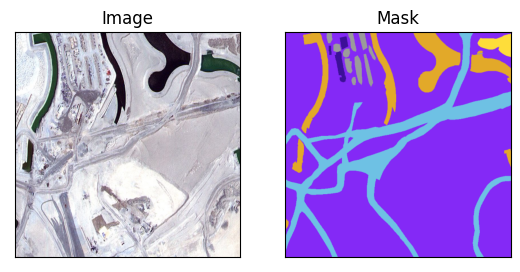

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
# rand_index = np.random.randint(low=0, high=images_array.shape[0])
rand_index = 0
ax1.imshow(images_array[rand_index])
ax1.set_title("Image")
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax2.imshow(masks_array[rand_index])
ax2.set_title("Mask")
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.show()

Split the data into train and test

In [18]:
# Keep the last tile as the test -> the rest for training
x_train, x_test = images_array[:-9], images_array[-9:]
y_train, y_test = masks_array[:-9], masks_array[-9:]

Data augmentation 

In [38]:
# Split the images and masks into smaller patches
pm = PatchMaker()
x_train_patches = np.array([pm.split(arr, (100,100,3), 100) for arr in x_train])
y_train_patches = np.array([pm.split(arr, (100,100,3), 100) for arr in y_train])

In [37]:
print(f"x_train contained {x_train.shape[0]} images of {x_train.shape[1], x_train.shape[2], x_train.shape[3]} shape\n"
        f"which was transformed into {x_train_patches.shape[0]} * {x_train_patches.shape[1]} = {x_train_patches.shape[0] * x_train_patches.shape[1]} images of shape "
            f"{x_train_patches.shape[2],x_train_patches.shape[3], x_train_patches.shape[4]}") 

x_train contained 63 images of (500, 500, 3) shape
which was transformed into 63 * 25 = 1575 images of shape (100, 100, 3)


Visualize the patches

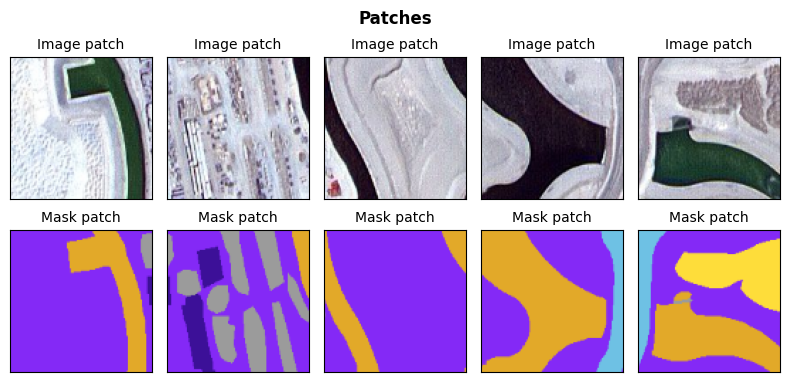

In [84]:
fig, axs = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle("Patches", weight='heavy')
for j in range(5):
    axs[0,j].imshow(x_train_patches[0][j])
    axs[0,j].set_title('Image patch', fontsize=10)
    axs[0,j].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

    axs[1,j].imshow(y_train_patches[0][j])
    axs[1,j].set_title('Mask patch', fontsize=10)
    axs[1,j].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

fig.tight_layout()
plt.subplots_adjust(top=.90)
plt.show()